In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings, datetime
warnings.filterwarnings('ignore')
%matplotlib inline

### Import and Prepare data

In [1]:
data = pd.read_excel('E:/Sales.xlsx')

NameError: name 'pd' is not defined

In [158]:
data.head()

,Billing Date,Customer,Material Number,Material Group,Qty,UoM,Net Value in Doc Currency
0,2019-06-02,10000003,100099,501,1920.0,KAR,1366867.14
1,2019-06-02,10000003,100101,503,1170.0,KAR,832934.68
2,2019-06-02,10000003,100107,504,690.0,KAR,491217.89
3,2019-06-02,10000003,100109,505,90.0,KAR,64071.90
4,2019-06-02,10000003,100105,503B,330.0,KAR,234930.30


In [159]:
data['Billing Date'] = pd.to_datetime(data['Billing Date'])

In [160]:
data.shape

(152773, 7)

In [161]:
data.count()

Billing Date                 152773
Customer                     152773
Material Number              152773
Material Group               152683
Qty                          152773
UoM                          152773
Net Value in Doc Currency    152773
dtype: int64

In [162]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152773 entries, 0 to 152772
Data columns (total 7 columns):
Billing Date                 152773 non-null datetime64[ns]
Customer                     152773 non-null int64
Material Number              152773 non-null object
Material Group               152683 non-null object
Qty                          152773 non-null float64
UoM                          152773 non-null object
Net Value in Doc Currency    152773 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 8.2+ MB


In [163]:
# Merging data by dates
data['Billing Date'] = data['Billing Date'].apply(lambda x: str(x)[:-9])  
data = data.groupby('Billing Date')['Net Value in Doc Currency'].sum().reset_index()
data.head()

,Billing Date,Net Value in Doc Currency
0,2019-04-01,50648642.57
1,2019-04-02,49487702.60
2,2019-04-03,58869847.96
3,2019-04-04,61066072.85
4,2019-04-05,60422859.61


In [164]:
data.shape

(91, 2)

In [165]:
# Set index as date
data.set_index('Billing Date', inplace= True)
data.dropna(inplace= True)
data.index = pd.to_datetime(data.index)

In [166]:
data.columns = ['Sales']

In [167]:
data.head()

,Sales
Billing Date,
2019-04-01,50648642.57
2019-04-02,49487702.60
2019-04-03,58869847.96
2019-04-04,61066072.85
2019-04-05,60422859.61


In [168]:
data.shape

(91, 1)

In [169]:
data.describe()

,Sales
count,9.100000e+01
mean,6.229109e+07
std,8.350709e+06
min,4.533778e+07
25%,5.642580e+07
50%,6.132992e+07
75%,6.675833e+07
max,8.844393e+07


### Visualise Data

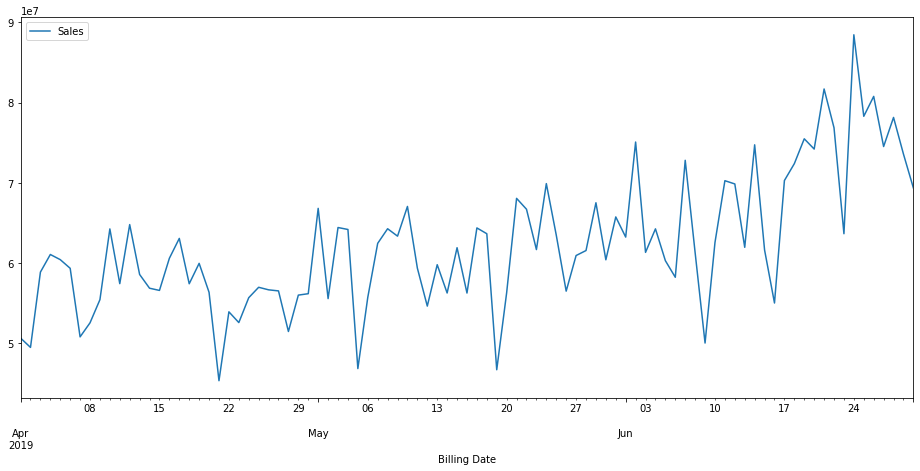

In [170]:
# Plot data of sales
data.plot(figsize = (16 , 7));

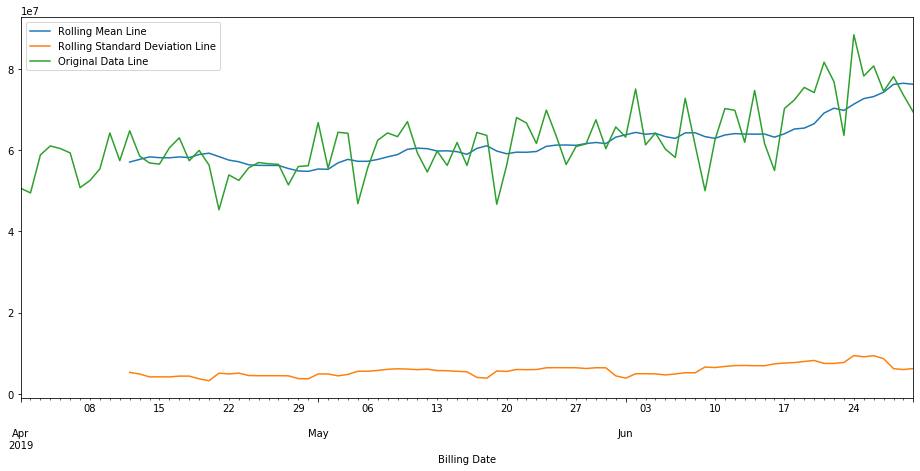

In [171]:
# Deviation of data with respect to mean of 12 days
data['Sales'].rolling(12).mean().plot(figsize = (16,7), label = 'Rolling Mean Line')
data['Sales'].rolling(12).std().plot(label = 'Rolling Standard Deviation Line')
data['Sales'].plot(label = 'Original Data Line')
plt.legend()
plt.show()

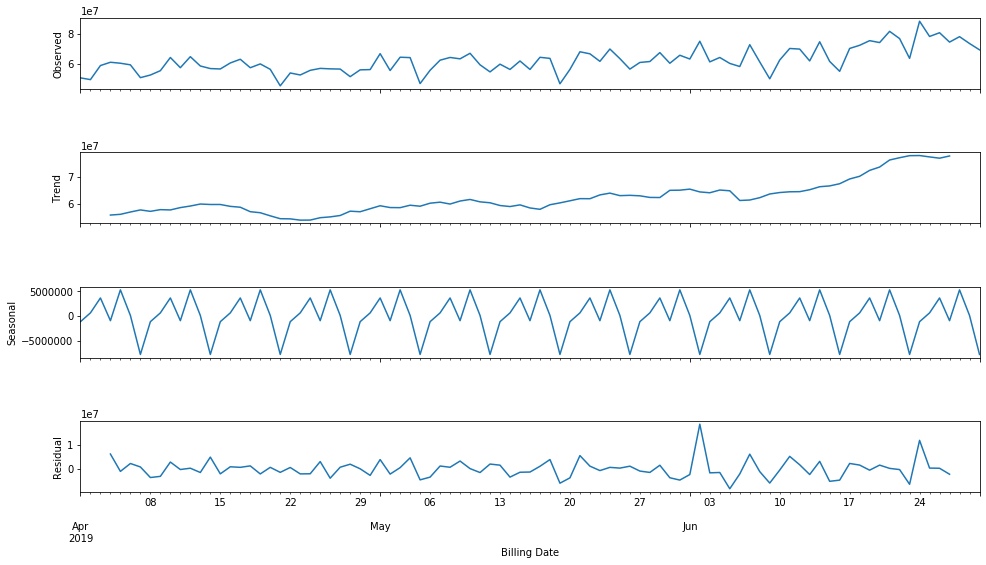

In [172]:
# To observe data in original data format-> observed
# trend -> rolling mean
# seasonal -> deviation in sales

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data['Sales'])
fig = decomposition.plot()
fig.set_size_inches(16,10)

### ADF test

In [173]:
from statsmodels.tsa.stattools import adfuller

In [174]:
def adf_check(time_series):
    print('\n------Dickey Fuller Test Results---------\n')
    result = adfuller(time_series)
    labels = ['ADF Test Statistic','p values','#Lags used','Number of Observations used']

    for value, label in zip(result, labels):
        print(label + ' : ' + str(value)+'\n')
    
    if result[1] <= 0.05:
        print('Since the evidence is strong enough we reject the null hypothesis so time series is stationary')
    else:
        print('Since the evidence is not enough we fail to reject the null hypothesis, so time series is not stationary')

In [175]:
adf_check(data['Sales'])


------Dickey Fuller Test Results---------

ADF Test Statistic : 0.3671719840476263

p values : 0.9802249013539144

#Lags used : 6

Number of Observations used : 84

Since the evidence is not enough we fail to reject the null hypothesis, so time series is not stationary


In [176]:
# From above try we got to know that this time series varies a lot
# So first we need to make it static
# To make it stationary we can add first difference and let's see what happens
# First difference = (current month sales - previous month sales)
data['First Difference'] = data['Sales'] - data['Sales'].shift(1)

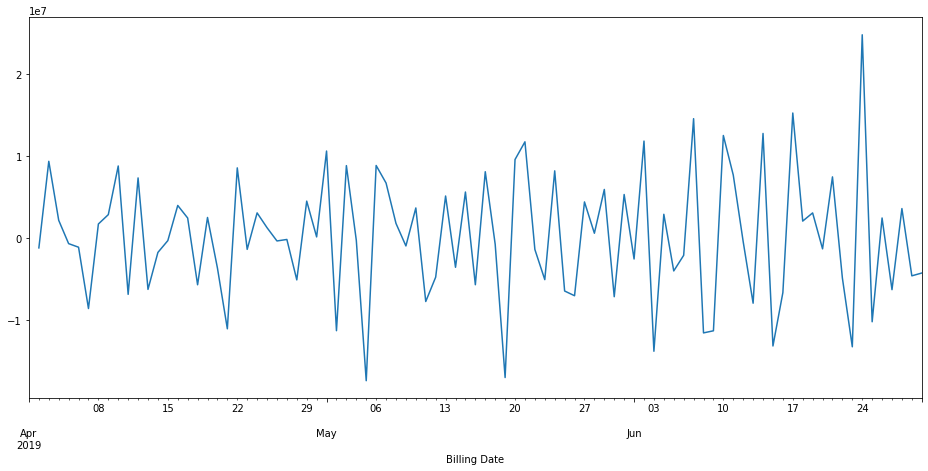

In [177]:
data['First Difference'].plot(figsize = (16,7));

In [178]:
adf_check(data['First Difference'].dropna())


------Dickey Fuller Test Results---------

ADF Test Statistic : -8.688566234708064

p values : 4.0993982344005624e-14

#Lags used : 5

Number of Observations used : 84

Since the evidence is strong enough we reject the null hypothesis so time series is stationary


In [179]:
# Nnow we have made our series stationary
# Here we have daily data so we can't define any season
# So leave that part

In [180]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [181]:
# Another way to see graph
from pandas.plotting import autocorrelation_plot

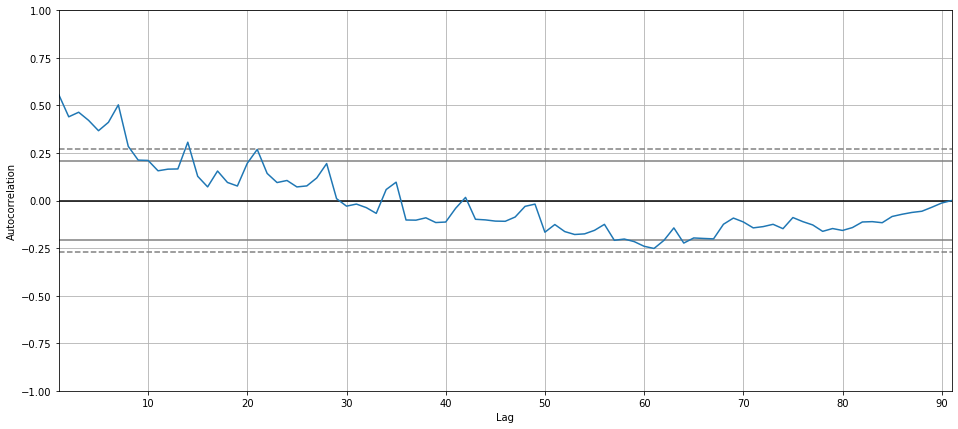

In [182]:
plt.figure(figsize= (16,7))
fig = autocorrelation_plot(data['Sales'].dropna())

### Plot below graphs to decide parameters in model

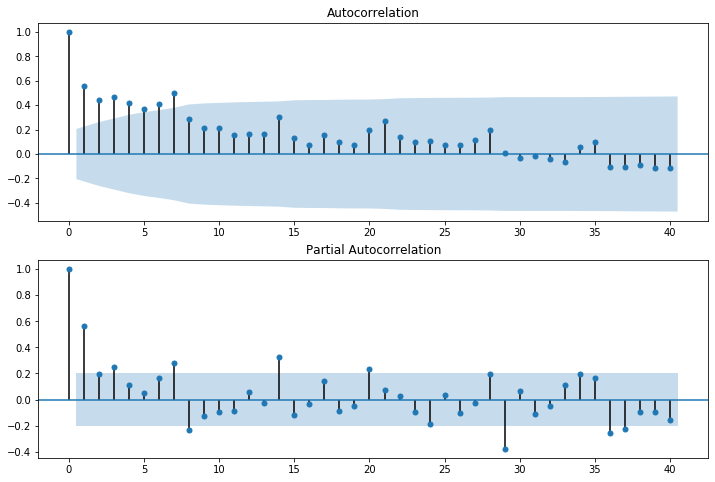

In [183]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Sales'].dropna(), lags=40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Sales'].dropna(), lags=40, ax= ax2)

In [184]:
from statsmodels.tsa.arima_model import ARIMA

In [185]:
X = data['Sales']
print(X)
size = (int)(len(X)*0.8)
train , test = X[0:size] , X[size:len(X)]
# This is new added line

Billing Date
2019-04-01    50648642.57
2019-04-02    49487702.60
2019-04-03    58869847.96
2019-04-04    61066072.85
2019-04-05    60422859.61
                 ...     
2019-06-26    80766128.61
2019-06-27    74517618.03
2019-06-28    78144314.95
2019-06-29    73580286.40
2019-06-30    69357869.46
Name: Sales, Length: 91, dtype: float64


In [186]:
history = [x for x in train]
predictions = list()

In [187]:
for t in range(len(test)):
    model = ARIMA(history, order=(2 , 1 , 2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=66660886.745420, expected=69855423.500000
predicted=65599918.884513, expected=61958985.830000
predicted=61999131.255435, expected=74731858.210000
predicted=68143091.624029, expected=61625204.600000
predicted=63730011.796697, expected=55018739.320000
predicted=62463651.701401, expected=70281703.910000
predicted=68355557.104660, expected=72384294.270000
predicted=66749646.916784, expected=75481911.900000
predicted=68579621.347292, expected=74203330.760000
predicted=69948330.986645, expected=81689255.730000
predicted=74681213.681306, expected=76857353.160000
predicted=72743310.574845, expected=63653219.380000
predicted=66743186.948736, expected=88443933.190000
predicted=79625606.089237, expected=78286168.370000
predicted=73081789.292832, expected=80766128.610000
predicted=80053066.036807, expected=74517618.030000
predicted=74444527.137817, expected=78144314.950000
predicted=78372677.095222, expected=73580286.400000
predicted=76148476.884508, expected=69357869.460000


In [188]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 8459106.943


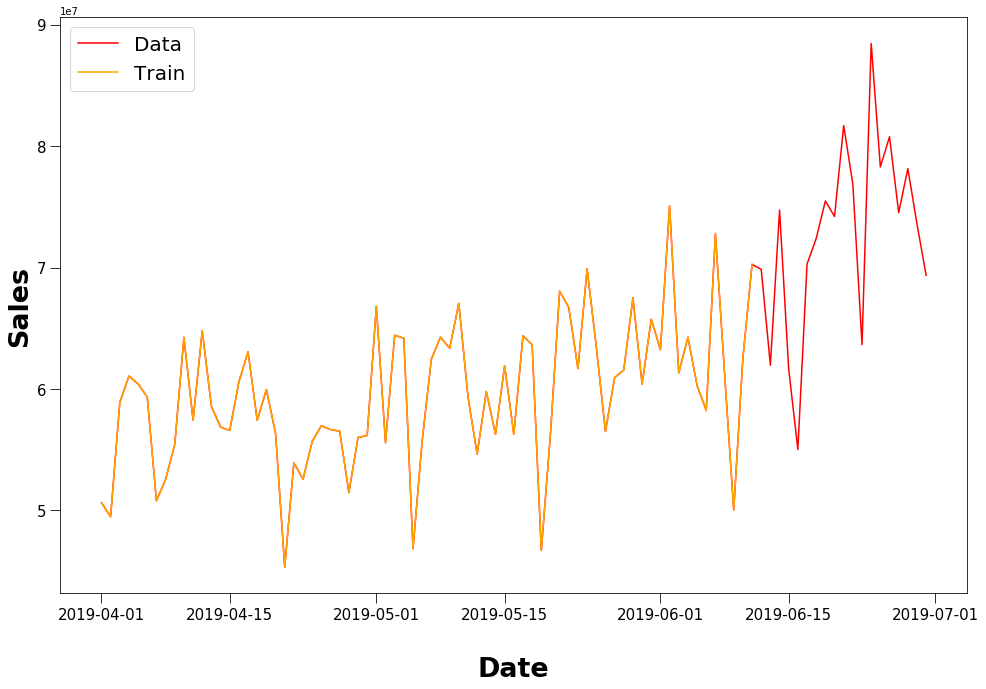

In [192]:
fig = plt.figure()
ax = fig.add_axes([0 , 0 , 2.1 , 2])
ax.plot(X , color = 'Red' , label = 'Data')
ax.plot(train , color = 'orange' , label = 'Train')
# ax.plot(np.array(predictions) , color = 'red' , label = 'Test Predict')
ax.set_xlabel('\nDate' , fontsize = 27 , fontweight = 'bold')
ax.set_ylabel('Sales' , fontsize = 27 , fontweight = 'bold')
ax.legend(loc = 'best' , prop = {'size' : 20})
ax.tick_params(size = 10 , labelsize = 15);

In [ ]:
model = ARIMA(data['Sales'] , order = (5 , 1 , 0))
model = model.fit()

In [ ]:
print(model.summary())

In [ ]:
residuals = pd.DataFrame(model.resid)
residuals.plot(figsize = (16,7))

In [ ]:
print(residuals.describe())

In [ ]:
# Predict known data first
data['Predicted'] = model.predict(start = 70 , end = 91 , dynamic = True)
data[['Predicted','Sales']].plot(figsize = (16,7));